In [1]:
%load_ext autoreload

%autoreload 2

%matplotlib inline

import os
try:
    os.chdir("L:\laupodteam\AIOS\Huibert-Jan\Celldynclustering\celldyn_embedder")
except FileNotFoundError:
    os.chdir('C:/Users/Huibert-Jan/Documents/Werk/UMCU/celldyn_embedder')    

import sys
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pacmap
import umap
import trimap

from scipy.stats import chisquare, chi2_contingency, pearsonr
from scipy.stats import kendalltau,spearmanr, weightedtau, theilslopes, wilcoxon, ttest_rel
from scipy.spatial import distance
import dcor

from sklearn.preprocessing import FunctionTransformer, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.manifold import Isomap, MDS, SpectralEmbedding
from sklearn.manifold import LocallyLinearEmbedding as LLE, TSNE, smacof, trustworthiness


from sklearn.metrics import rand_score, adjusted_mutual_info_score, adjusted_rand_score
from sklearn.metrics import calinski_harabasz_score, davies_bouldin_score
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.cluster import KMeans

from src.utils.distance import poincarre_dist
from src.utils.quality_metrics import CDEmbeddingPerformance
import numpy.linalg as la
import torch 

from numba import njit

import faiss




In [8]:
celldyn_full = pd.read_feather("L:\laupodteam\AIOS\Bram\data\CellDyn\\artifacts\celldyn_FULL_transformed_miceforest100_df.feather")
meas_columns = [c for c in celldyn_full.columns if ('c_b' in c) | ("COMBO" in c)]
mode_columns = [c for c in celldyn_full.columns if 'c_m' in c]
alrt_columns = [c for c in celldyn_full.columns if 'alrt' in c.lower()]
c_s_columns = [c for c in celldyn_full.columns if 'c_s_' in c.lower()]

In [11]:
embedder_full = umap.UMAP(n_components=6,metric = poincarre_dist,n_neighbors=50,min_dist = 0.0,n_jobs=4,n_epochs=400)
le_pipe = Pipeline([('scaler', StandardScaler()),
                    ('embedder', embedder_full)])

le_pipe.fit(celldyn_full[meas_columns].to_numpy(dtype = np.float32)) # final_columns

c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\umap\umap_.py:1772: UserWarning: custom distance metric does not return gradient; inverse_transform will be unavailable. To enable using inverse_transform method, define a distance function that returns a tuple of (distance [float], gradient [np.array])
  warn(


TypingError: Failed in nopython mode pipeline (step: nopython frontend)
Internal error at <numba.core.typeinfer.CallConstraint object at 0x000001B892335E80>.
[1m[1m[1mcan't compile poincarre_dist: import of module utils failed[0m
[0m[1mDuring: resolving callee type: type(CPUDispatcher(<function init_rp_tree at 0x000001B8A7196A60>))[0m
[0m[1mDuring: typing of call at c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\pynndescent\pynndescent_.py (339)
[0m
Enable logging at debug level for details.
[1m
File "c:\Users\hjoosse3\.conda\envs\embcelldyn\lib\site-packages\pynndescent\pynndescent_.py", line 339:[0m
[1mdef nn_descent(
    <source elided>
        if rp_tree_init:
[1m            init_rp_tree(data, dist, current_graph, leaf_array)
[0m            [1m^[0m[0m


In [ ]:
embedded_data = pd.DataFrame(le_pipe.named_steps['embedder'].embedding_,columns=[f'dim_{i+1}' for i in range(le_pipe.named_steps['embedder'].embedding_.shape[1])])

In [ ]:

embedded_data['sex'] = celldyn_full.gender
embedded_data['age'] = celldyn_full.age
embedded_data['study_id'] = celldyn_full.studyid_alle_celldyn
embedded_data['analysis_dt'] = celldyn_full.asp_dt
embedded_data['sample_dt'] = celldyn_full.afname_dt


In [ ]:
embedded_data.to_feather("L:/lab_research/RES-Folder-UPOD/Celldynclustering/E_ResearchData/2_ResearchData/embedded_celldyn_FULL_nn50_ndim6_w_labels_w_ratio_mf100.feather")

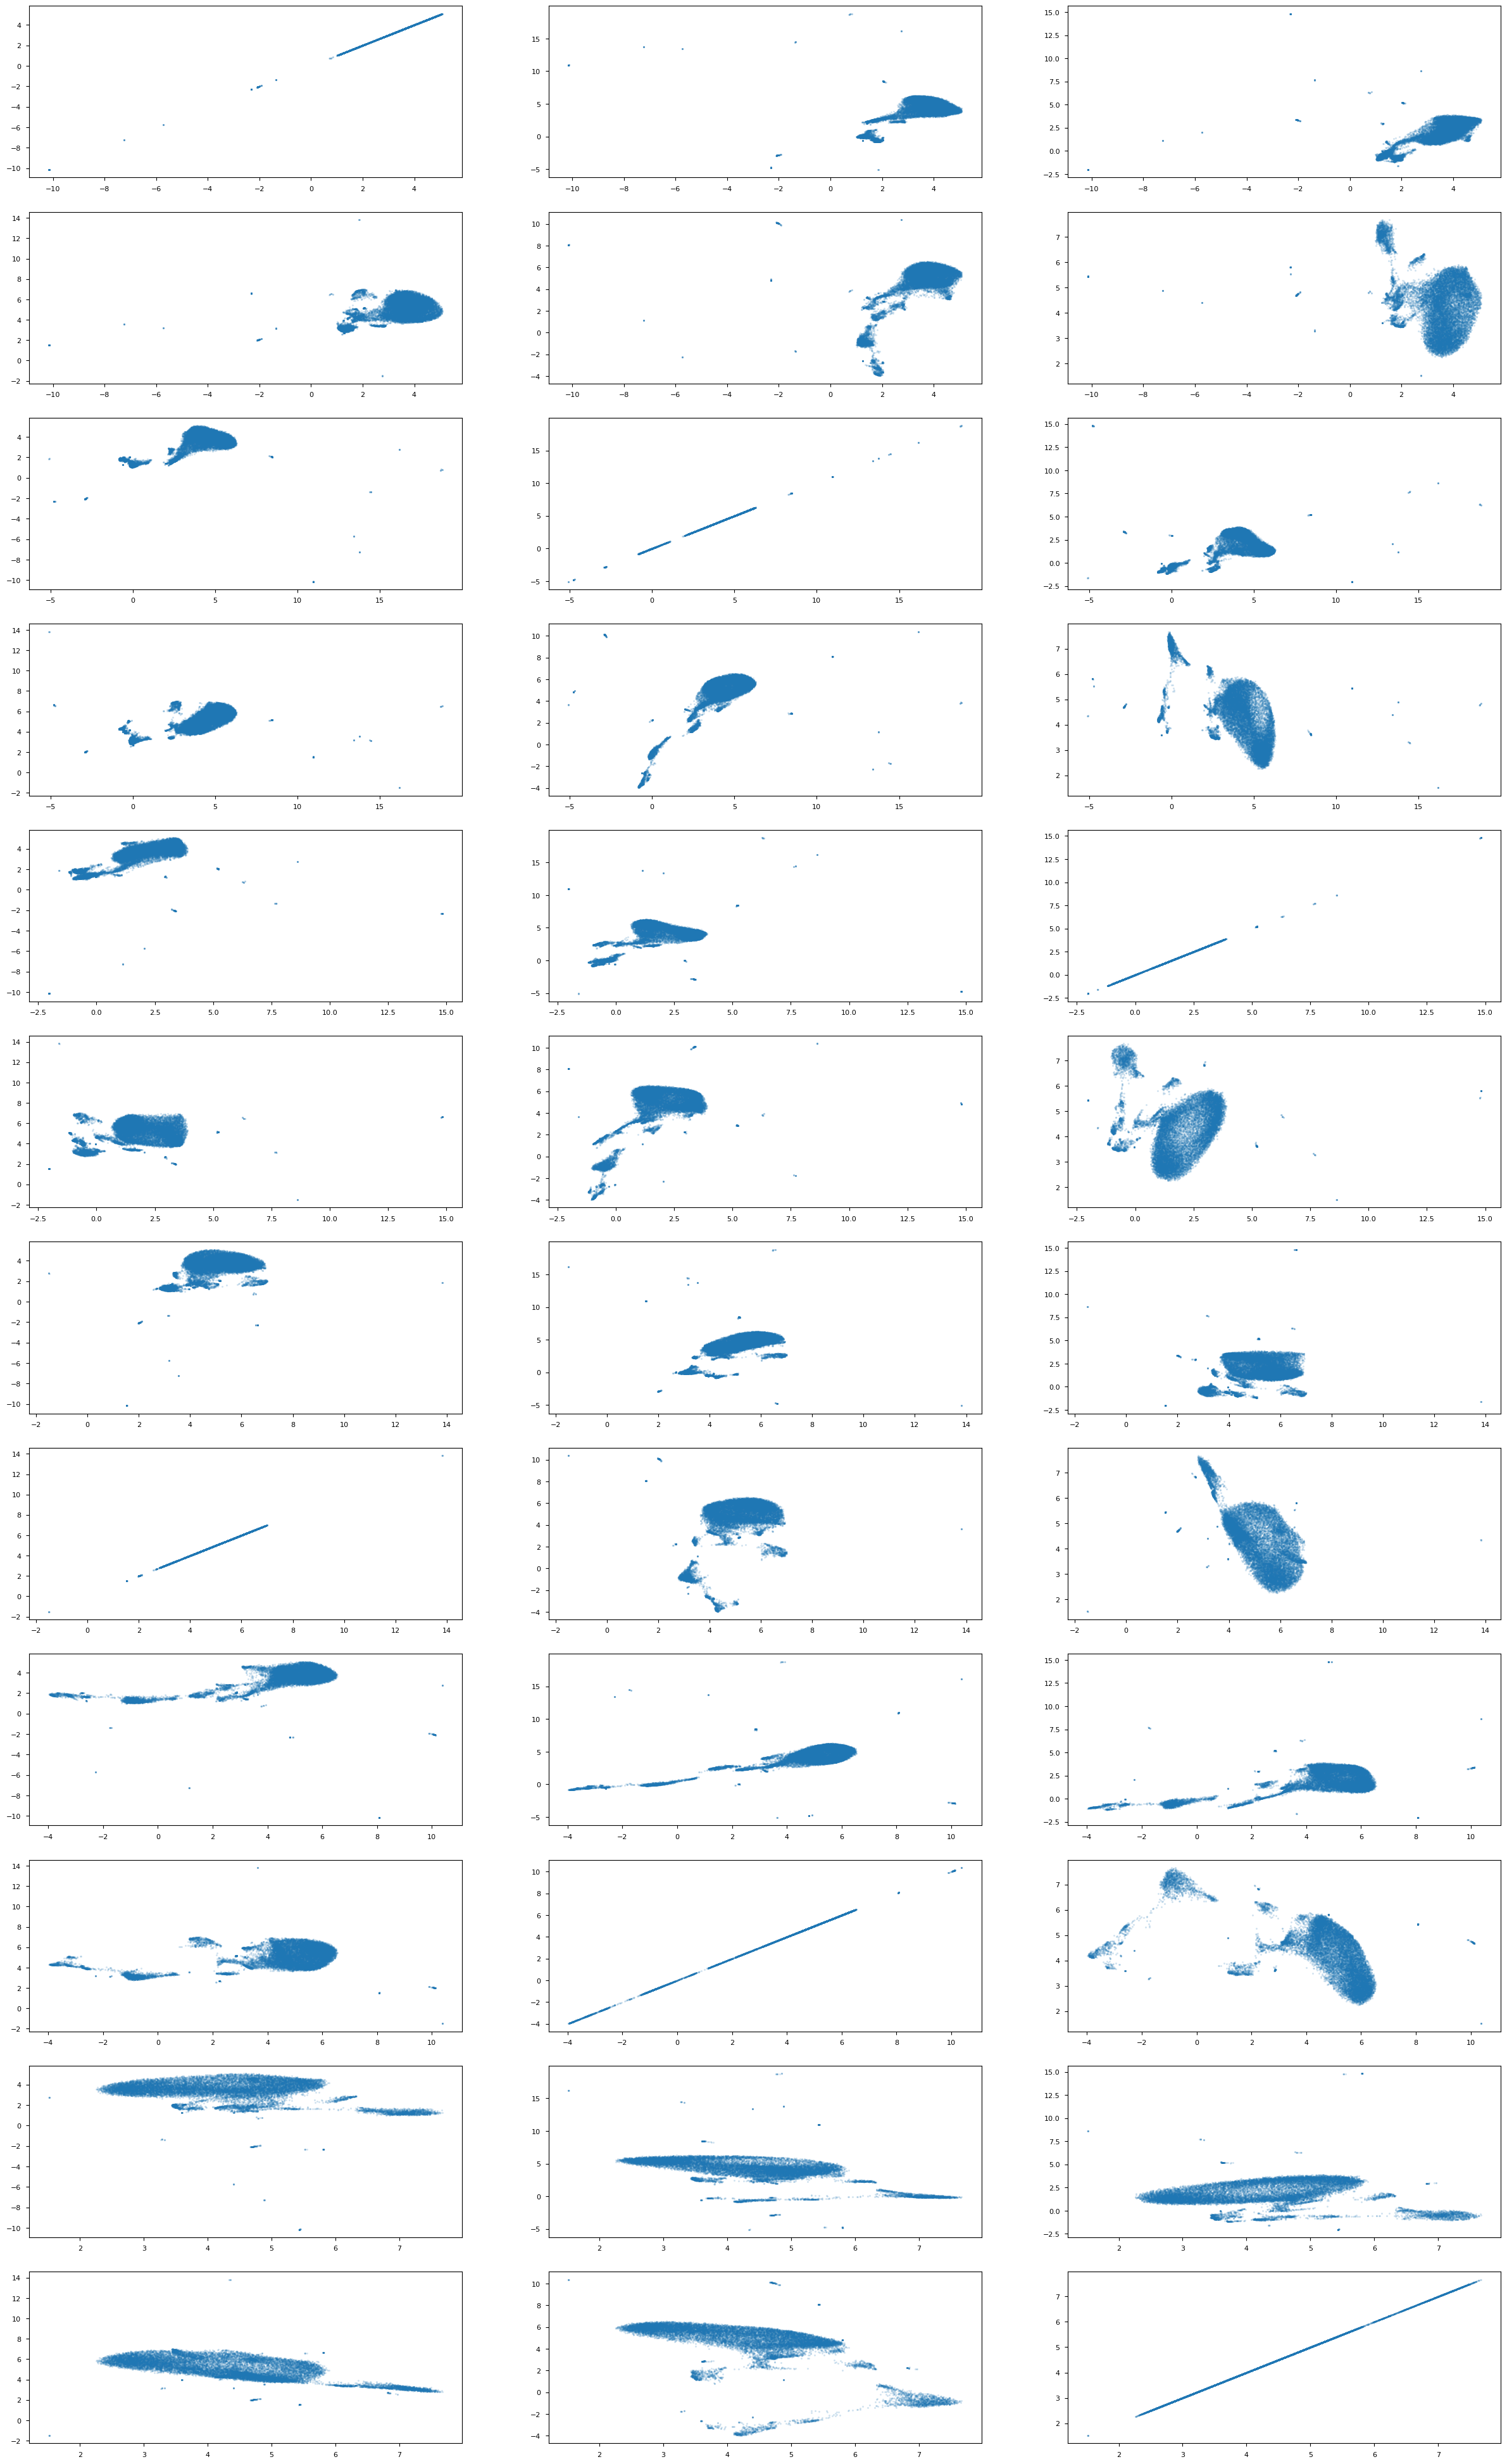

In [ ]:
plt.style.use("seaborn-paper")

plot_df = pd.DataFrame(le_pipe.named_steps.embedder.embedding_,columns = [f'dim_{i}' for i in range(1,7)]).sample(20000)
plot_df['sex'] = celldyn_full.gender

fig, ax = plt.subplots(12,3,figsize = (30,50))
i,j = 0,0

for colx in plot_df[[c for c in embedded_data if 'dim' in c]]:
    for coly in plot_df[[c for c in embedded_data if 'dim' in c]]:
        ax[i,j].scatter(plot_df[colx],plot_df[coly], s = 3, alpha = 0.2)
        i = i+1 if j == 2 else i
        j = j+1 if j < 2 else 0
        
